In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import random
from  pmdarima.arima import ARIMA, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
import tensorflow.keras as keras
import warnings
warnings.simplefilter("ignore")

time: 787 µs (started: 2022-04-28 15:11:51 +00:00)


# Prepare data

In [51]:
df = pd.read_csv("./stock08_price.csv")
portfolio = ['CNP', 'WBA']

time: 96.4 ms (started: 2022-04-28 15:11:52 +00:00)


In [52]:
stock_price_df = pd.read_csv("./stock08_price.csv")
pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))

tmp_corr = stock_price_df[portfolio[0]].rolling(window=100).corr(stock_price_df[portfolio[1]])
tmp_corr = tmp_corr.iloc[99::100][:21]
unseen_data_df = pd.DataFrame(tmp_corr).reset_index().drop(['Date'],axis=1).T
unseen_data_df.to_csv("./stock_correlation_prediction/use_hybrid_model/before_arima/unseen_data.csv")

time: 95.6 ms (started: 2022-04-28 15:11:53 +00:00)


### original data preprocess

In [3]:
def rolling_corr(item1,item2) :
    #import data
    stock_price_df = pd.read_csv("./stock08_price.csv")
    pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
    stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))
    
    #calculate
    df_pair = pd.concat([stock_price_df[item1], stock_price_df[item2]], axis=1)
    df_corr = df_pair[item1].rolling(window=100).corr(df_pair[item2])
    return df_corr

time: 491 µs (started: 2022-04-28 08:55:14 +00:00)


In [4]:
index_list = []
for _ in range(100):
    indices = []
    for k in range(_, 2420,100):
        indices.append(k)
    index_list.append(indices)
    
data_matrix = []
count = 0
for i in range(2):
    for j in range(1-i):
        a = portfolio[i]
        b = portfolio[1-j]
        file_name = a + '_' + b
            
        corr_series = rolling_corr(a, b)[99:]
        for _ in range(100):
            corr_strided = list(corr_series[index_list[_]][:24]).copy()
            data_matrix.append(corr_strided)
            count+=1
            if count % 1000 == 0 :
                print(str(count)+' items preprocessed')
                
data_matrix = np.transpose(data_matrix)
data_dictionary = {}
for i in range(len(data_matrix)):
    data_dictionary[str(i)] = data_matrix[i]
data_df = pd.DataFrame(data_dictionary)
data_df.to_csv('./stock_correlation_prediction/use_hybrid_model/dataset.csv')

time: 117 ms (started: 2022-04-28 08:55:14 +00:00)


In [5]:
data_df = pd.read_csv('./stock_correlation_prediction/use_hybrid_model/dataset.csv')
data_df = data_df.loc[:, ~data_df.columns.str.contains('^Unnamed')]
print(data_df.shape)

(100, 24)
time: 2.29 ms (started: 2022-04-28 08:55:14 +00:00)


In [6]:
num_list = []
for i in range(24):
    num_list.append(str(i))
data_df = data_df[num_list].copy()
data_df = np.transpose(data_df)
print(data_df.shape)
print(data_df.head())

(24, 100)
         0         1         2         3         4         5         6   \
0  0.059740  0.083716  0.112548  0.147554  0.175401  0.204664  0.239121   
1  0.853850  0.866527  0.875764  0.878951  0.884143  0.890690  0.895338   
2  0.243517  0.284944  0.329033  0.371055  0.403507  0.427554  0.451566   
3  0.564273  0.558247  0.556887  0.554903  0.563673  0.574147  0.580041   
4  0.870768  0.873113  0.873268  0.876029  0.879022  0.881985  0.885425   

         7         8         9   ...        90        91        92        93  \
0  0.281801  0.327192  0.351782  ...  0.342741  0.389158  0.433774  0.496796   
1  0.899531  0.903189  0.904905  ... -0.241695 -0.266245 -0.272593 -0.226259   
2  0.473680  0.486588  0.504278  ...  0.603275  0.621260  0.632354  0.636016   
3  0.590937  0.604755  0.609349  ...  0.809650  0.813857  0.818798  0.830005   
4  0.888059  0.890532  0.894558  ...  0.560232  0.546140  0.535070  0.532075   

         94        95        96        97        98       

In [7]:
indices = [20*k for k in range(5)]
data_df = pd.DataFrame(data_df[indices])

unseen_data = []

for i in range(data_df.shape[1]):
    tmp = data_df[20*i].copy()
    unseen_data.append(tmp[:21])
    
unseen_data = pd.DataFrame(unseen_data)

unseen_data.to_csv('./stock_correlation_prediction/use_hybrid_model/before_arima/unseen_data.csv')

time: 2.47 ms (started: 2022-04-28 08:55:14 +00:00)


# ARIMA model

In [53]:
dataset = pd.read_csv('./stock_correlation_prediction/use_hybrid_model/before_arima/unseen_data.csv')
dataset = dataset.loc[:,~dataset.columns.str.contains('Unnamed')]

# model_110 = ARIMA(order=(1,1,0), mle_regression=True, suppress_warnings=True)
# model_011 = ARIMA(order=(0,1,1), mle_regression=True, suppress_warnings=True)
# model_111 = ARIMA(order=(1,1,1), mle_regression=True, suppress_warnings=True)
# model_211 = ARIMA(order=(2,1,1), mle_regression=True, suppress_warnings=True)
# model_210 = ARIMA(order=(2,1,0), mle_regression=True, suppress_warnings=True)
model_110 = ARIMA(order=(1,1,0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
model_011 = ARIMA(order=(0,1,1), out_of_sample_size=0,  mle_regression=True, suppress_warnings=True)
model_111 = ARIMA(order=(1,1,1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
model_211 = ARIMA(order=(2,1,1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
model_210 = ARIMA(order=(2,1,0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
model_330 = ARIMA(order=(3,3,0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)


flag = 0
c=0
residual = []
for s in np.array(dataset):
    c+=1
    try:
        model1 = model_110.fit(s)
        model = model1
        print("model1")

        try:
            model2 = model_011.fit(s)

            if model.aic() <= model2.aic() :
                pass
            else :
                model = model2
                print("model2")

            try :
                model3 = model_111.fit(s)
                if model.aic() <= model3.aic() :
                    pass
                else :
                    model = model3
                    print("model3")
            except :
                try:
                    model4 = model_211.fit(s)

                    if model.aic() <= model4.aic() :
                        pass
                    else:
                        model = model4
                        print("model4")
                except:
                    try:
                        model5 = model_210.fit(s)

                        if model.aic() <= model5.aic():
                            pass
                        else :
                            model = model5
                            print("model5")
                    except :
                        pass

        except:
            try:
                model3 = model_111.fit(s)

                if model.aic() <= model3.aic() :
                    pass
                else :
                    model = model3
                    print("model3")
            except :
                try:
                    model4 = model_211.fit(s)

                    if model.aic() <= model4.aic() :
                        pass
                    else:
                        model = model4
                        print("model4")
                except:
                    try:
                        model5 = model_210.fit(s)

                        if model.aic() <= model5.aic():
                            pass
                        else :
                            model = model5
                            print("model5")
                    except :
                        pass

    except:
        try:
            model2 = model_011.fit(s[i])
            model = model2
            print("model2")

            try :
                model3 = model_111.fit(s[i])

                if model.aic() <= model3.aic():
                    pass
                else:
                    model = model3
                    print("model3")
            except :
                try:
                    model4 = model_211.fit(s[i])

                    if model.aic() <= model4.aic() :
                        pass
                    else:
                        model = model4
                        print("model4")
                except:
                    try:
                        model5 = model_210.fit(s[i])

                        if model.aic() <= model5.aic():
                            pass
                        else :
                            model = model5
                            print("model5")
                    except :
                        pass

        except :
            try:
                model3 = model_111.fit(s[i])
                model = model3
                print("model3")
            except :
                try:
                    model4 = model_211.fit(s[i])

                    if model.aic() <= model4.aic() :
                        pass
                    else:
                        model = model4
                        print("model4")
                except:
                    try:
                        model5 = model_210.fit(s[i])

                        if model.aic() <= model5.aic():
                            pass
                        else :
                            model = model5
                            print("model5")
                    except :
                        flag = 1
                        print(str(c) + " FATAL ERROR")
                        break

                        
    arima_pred = list(model.predict_in_sample())
    arima_pred = [np.mean(arima_pred[1:])] + arima_pred[1:]

    res = pd.Series(np.array(s) - np.array(arima_pred))
    residual.append(np.array(res)[:20])


    if flag == 1:
        break
residual = pd.DataFrame(residual)
residual.to_csv('./stock_correlation_prediction/use_hybrid_model/unseen_residual_after_arima.csv')

model1
model2
time: 92.4 ms (started: 2022-04-28 15:12:01 +00:00)


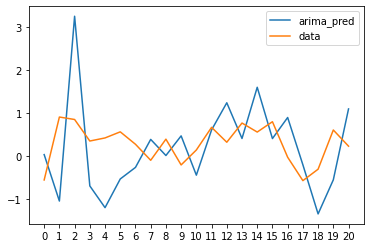

time: 101 ms (started: 2022-04-28 14:43:29 +00:00)


In [49]:
arima_pred = model_330.fit(np.array(dataset)[0]).predict_in_sample()
plt.plot(arima_pred, label="arima_pred")
plt.plot(dataset.T, label="data")
# plt.plot(res, label="res")
plt.legend()
plt.show()
plt.close()

# LSTM

In [54]:
class Double_Tanh(Activation):
    def __init__(self, activation, **kwargs):
        super(Double_Tanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'

def double_tanh(x):
    return (K.tanh(x) * 2)

get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})

unseen_res = residual.values.reshape((-1,20,1))
filepath = './stock_correlation_prediction/models/hybrid_LSTM/epoch262.h5'
custom_objects = {"Double_Tanh": Double_Tanh}
with keras.utils.custom_object_scope(custom_objects):
    model = load_model(filepath)
    lstm_pred = model.predict(unseen_res)

time: 427 ms (started: 2022-04-28 15:12:08 +00:00)


In [59]:
print(f"lstm pred:{lstm_pred}, arima_pred: {arima_pred[-1]}, hybrid_model_pred={arima_pred[-1]+lstm_pred[0][0]}, ground truth: {dataset.iloc[0, -1]}")

lstm pred:[[0.03877307]], arima_pred: 0.18902656671614293, hybrid_model_pred=0.22779963401169423, ground truth: 0.2300556621642169
time: 734 µs (started: 2022-04-28 15:13:48 +00:00)
